In [55]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<br>

## 1. Preparing dataset

#### Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes <- 우리 정답열
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) <- 1,2,3등실
- **sibsp** : # of siblings & spouses aboard the Titanic <- 본인 제외 형제자매배우자 수
- name <- 버릴까 말까 고민해봐
- sex <- 0/1로 변환 가능, replace or apply
- age <- standard scaler 적용해야겠구나
- **parch** : # of parents / children aboard the Titanic <- 본인 제외 부모 or 자식
- **ticket** : Ticket number
- fare <- 얼마내도 탔냐
- **cabin** : Cabin number <-결측치 많아 고민해봐
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) <- 어디서 승선했는지 항구

In [56]:
data_df = pd.read_csv('titanic.csv')
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
y_data = data_df[['Survived']]
x_data = data_df.copy()

<br>

## 2. Feature engineering & Feature selection

### a) 데이터 탐색

In [58]:
x_data.info()
# 1. Age열의 결측치 비율이 약 20% -> 결측치 포함 열을 떨구기엔 가진 데이터셋이 너무 적다 판단 -> 결측치 채우기
# 2. Cabin열의 결측치 비율이 약 77% -> 유의미한 결과를 끌어내기 어렵겠다 판단 -> 열 삭제 
# 3. Embarked열의 결측치 2개. (주관적인 판단) 결측치가 포함된 모든 열을 지워줘도 괜찮겠다 결과엔 크게 영향을 주지 않겠다 판단

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### b) 기존 열을 바탕으로 새로운 열 추가 

In [59]:
# 데이터 탐색 과정 중 발견한 것) 
# - 같은 Pclass라도 Ticket number에 따라 요금 편차가 매우 큼 (그 편차가 group에 비례)
# - 3등석 Fare이 1등석 Fare보다 높은 경우 확인 (이 경우도 그 편차가 group수에 비례)
# => (결론) Fare == 동일한 Ticket number를 가진 탑승자들의 총 요금 -> Fare/Group size == 단일 티켓의 가격
x_data.groupby(['Pclass','Ticket','Fare']).size().head()

Pclass  Ticket  Fare 
1       110152  86.50    3
        110413  79.65    3
        110465  52.00    2
        110564  26.55    1
        110813  75.25    1
dtype: int64

In [60]:
# ticket count열 생성 
grouped_ticket = pd.DataFrame(x_data.groupby(['Ticket']).size()).reset_index() # new grouped result
grouped_ticket.columns = ['Ticket', 'Ticket Counts'] # set columns name
x_data = x_data.merge(grouped_ticket, on='Ticket', how='left')

In [61]:
# Fare per ticket 열 추가 
x_data['Fare per ticket']  = round(x_data['Fare'] / x_data['Ticket Counts'],4)

In [62]:
# 추가) SibSp (형제자매,배우자) & Parch (부모, 자식) & Ticket Counts를 보면, 동승자의 존재 여부를 알 수 있을 것. => 모두 더해 1이면 동승자 X, 1이 아니면 동승자 O. 
# Group (==추정 동승자 수 ) 열 추가 
x_data['Group'] = x_data['SibSp'] + x_data['Parch'] + x_data['Ticket Counts']
x_data['Group'] = x_data['Group'].apply(lambda x : 0 if x == 1 else 1)

In [63]:
x_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket Counts,Fare per ticket,Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,71.2833,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,7.9250,0


In [64]:
# Name 열: 열마다 title이 다름
names = list(data_df['Name'])
titles = []
for name in names:
    title = name.split(', ')[1].split('.')[0]
    titles.append(title)
print(set(titles))

def popTitle(name):
    title = name.split(', ')[1].split('.')[0]
    return title

x_data['Name'] = x_data['Name'].apply(lambda x : popTitle(x))

# # 여기서 x_data 는 원본 데이터
# temp = x_data[x_data['Age'].notna()] #isnull()

# names = list(temp['Name'])
# titles = []
# for name in names:
#     title = name.split(', ')[1].split('.')[0]
#     titles.append(title)
# print(set(titles))
# temp.info()

{'Dr', 'Lady', 'Miss', 'Ms', 'Mlle', 'Capt', 'Mrs', 'Rev', 'Sir', 'Don', 'Col', 'the Countess', 'Jonkheer', 'Major', 'Mr', 'Master', 'Mme'}


<군 계급>
Major - (군에서) 가장 높은 계급
Col - 두번째로 높은 계급
Capt - 세번째로 높은 계급 
-> 군 title을 가진 사람 1, 아닌 사람 0 -> military 열 추가

<귀족 계급>
Jonkheer - 가장 낮은 계급의 귀족
the Countess -  귀족
Lady -  왕족 딸
-> 귀족 계급인 사람 1, 아닌 사람 0 -> nobility 열 추가

<나이(?)>
Don - 고령자
Master - 어린 남자 아이, Lady - 왕족 딸, Miss & Mlle - 미혼 여성
-> Master/Lady/Miss/Mller 0, 위에 기재되지 않은 title 1, 고령자 2 -> est_age 열 추가

In [65]:
x_data['Group'] = x_data['Group'].apply(lambda x : 0 if x == 1 else 1)  # 0: 혼자/ 1: 동행인이 있는 경우

x_data['Military'] = x_data['Name'].apply(lambda x : 0 if x in ['Major','Col','Capt'] else 1)

x_data['Nobility'] = x_data['Name'].apply(lambda x : 0 if x in ['Jonkheer','the Countess','Lady'] else 1)

x_data['est_age'] = x_data['Name'].apply(lambda x : 2 if x=='Don' else (0 if x in ['Master','Lady','Miss','Mlle'] else 1))

In [66]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                714 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
Ticket Counts      891 non-null int64
Fare per ticket    891 non-null float64
Group              891 non-null int64
Military           891 non-null int64
Nobility           891 non-null int64
est_age            891 non-null int64
dtypes: float64(3), int64(10), object(5)
memory usage: 132.3+ KB


### c) 불필요한 열/행 제거 

In [67]:
# 2. 불필요한 열 제거 : Cabin + PassengerId (고유값) , Name, Ticket, 
del x_data['Cabin']
del x_data['PassengerId']
del x_data['Name']
del x_data['Ticket']

In [68]:
# 3. Embarked에 결측치가 포함 행 제거 
x_data = x_data.dropna(subset=['Embarked'])

### d) Numeric -> Categorical data 변환

In [69]:
# (모델의 정확도 향상을 기대)
# 형제자매/배우자 유무
x_data['SibSp']=x_data['SibSp'].apply(lambda x : 0 if x == 0 else 1)
# 부모/자식 유무
x_data['Parch']=x_data['Parch'].apply(lambda x : 0 if x == 0 else 1)

### e) Text -> Number data 변환

In [70]:
# Sex 열) male = 0, female = 1
x_data['Sex']=x_data['Sex'].apply(lambda x : 0 if x == 'male' else 1)

# Group 열) 개인 = 0, 동승자가 있다면 = 1
x_data['Group'] = x_data['Group'].apply(lambda x : 0 if x == 1 else 1)

# Embarked / C: 0, Q:1 , S:2
x_data['Embarked'] = x_data['Embarked'].apply(lambda x : 0 if x== 'C' else (1 if x=='Q' else 2))

### f) 결측치 채우기 

In [71]:
x_data.corr().abs().sort_values(by='Age') # 상관관계가 높은 열 순서 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket Counts,Fare per ticket,Group,Military,Nobility,est_age
Embarked,0.169718,0.164681,0.110320,0.032565,0.013810,0.003172,0.226311,1.000000,0.049243,0.276080,0.098489,0.006134,0.014855,0.066442
Nobility,0.034030,0.091486,0.038492,0.045025,0.001873,0.032663,0.011641,0.014855,0.005159,0.013919,0.021704,0.004376,1.000000,0.011341
Survived,1.000000,0.335549,0.541585,0.082446,0.118087,0.149328,0.255290,0.169718,0.037872,0.252607,0.239482,0.002716,0.034030,0.348568
Fare,0.255290,0.548193,0.179958,0.093143,0.193970,0.239264,1.000000,0.226311,0.345573,0.838678,0.403348,0.008969,0.011641,0.114479
Sex,0.541585,0.127741,1.000000,0.099037,0.205817,0.249837,0.179958,0.110320,0.154597,0.126031,0.316734,0.055303,0.038492,0.566127
Military,0.002716,0.118241,0.055303,0.156535,0.019105,0.006977,0.008969,0.006134,0.032438,0.046751,0.042196,1.000000,0.004376,0.043000
SibSp,0.118087,0.078671,0.205817,0.160784,1.000000,0.419741,0.193970,0.013810,0.441797,0.091484,0.710827,0.019105,0.001873,0.131335
Group,0.239482,0.216036,0.316734,0.187924,0.710827,0.583880,0.403348,0.098489,0.601406,0.240503,1.000000,0.042196,0.021704,0.216712
Fare per ticket,0.252607,0.654483,0.126031,0.224867,0.091484,0.102253,0.838678,0.276080,0.013503,1.000000,0.240503,0.046751,0.013919,0.012166
Ticket Counts,0.037872,0.002089,0.154597,0.255000,0.441797,0.534633,0.345573,0.049243,1.000000,0.013503,0.601406,0.032438,0.005159,0.252627


In [72]:
# 1. Age 열 결측치 채우기 
# Age 결측치를 채워주는 방법으로, 가지고있는 714개의 데이터 바탕 -> 여러 회귀 모델을 돌려 -> MSE값이 가장 낮은 모델로 얻은 예측치 -> 결측치 값 추가

import numpy as np
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

x_data_withAge = x_data[x_data['Age'].notna()] # age 값이 있는 행만 추린 df


classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(), # MSE < 1. MSE가 가장 작게 나옴. 
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]

X = np.array(x_data_withAge[x_data_withAge.columns.difference(['Age'])]) # Age를 제외한 모든 열
y = np.array(x_data_withAge['Age'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)


for item in classifiers:
    print(item)
    model = item
    model.fit(X_train, y_train)
    print('MSE(Training data) : ', mean_squared_error(model.predict(X_train), y_train))
    
## **다른 모델 데이터도 추가 -> 성능 비교 -> 다음 cell clf 결정할 것 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
MSE(Training data) :  172.82471811232057
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)
MSE(Training data) :  2.212070596358961e+25
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
MSE(Training data) :  115.42047944599396
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     

In [73]:
# 결측치 추가 (**우선적으로 SGDRegressor 모델로 채움. 추후 다른 모델과 성능 비교 후 수정 필요)
clf = classifiers[-1]

age_pred = clf.predict(x_data[x_data.columns.difference(['Age'])])

x_data['Age'].fillna(pd.Series(age_pred.flatten()), inplace=True) 

In [74]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 14 columns):
Survived           889 non-null int64
Pclass             889 non-null int64
Sex                889 non-null int64
Age                889 non-null float64
SibSp              889 non-null int64
Parch              889 non-null int64
Fare               889 non-null float64
Embarked           889 non-null int64
Ticket Counts      889 non-null int64
Fare per ticket    889 non-null float64
Group              889 non-null int64
Military           889 non-null int64
Nobility           889 non-null int64
est_age            889 non-null int64
dtypes: float64(3), int64(11)
memory usage: 104.2 KB


## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression,make_classification
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, model_selection, linear_model
from sklearn import neighbors
from sklearn import datasets, ensemble
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc

### Logistic Regression 모델
- 이진 분류문제를 해결하기 위한 모델
- 데이터의 정규 분포도에 따라 예측 성능 영향을 받을 수 있으므로 정규 분포 형태의 표준 스케일링을 적용
- C 값을 hyper-parameter로 받음

In [76]:
# 로지스틱회귀로 예측모델 검증하기
logistic_X = x_data[x_data.columns.difference(['Survived'])] # Survived열 제외 모든 열을 X값으로 
logistic_Y = np.array(x_data['Survived']) # Survived열을 y값으로

# Create model object 
model_logistic = linear_model.LogisticRegression(C=5)

# <Feature scaling> 
# 각 column의 데이터의 scale을 맞춰주는 정규화 과정을 거쳐야함. 
numeric_features = ['Age','Fare','Ticket Counts','Fare per ticket','est_age'] 
numeric_transformer = StandardScaler() # numeric 열 scaler 생성


categorical_features = ['Pclass','SibSp','Parch','Embarked','Group','Military','Nobility']
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # categorical 열 scaler 생성


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Feature sacaling pipline이 적용된 새로운 logistic 
new_model_logistic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model_logistic)])

# train/testing 데이터 분류
X_train, X_test, y_train, y_test = train_test_split(logistic_X,logistic_Y,test_size=0.3,random_state=0)

new_model_logistic.fit(X_train,y_train) # 로지스틱모델 학습

# 모델 종류/ x test 데이터/ y test 데이터를 넣었을 때, Accuracy & AUC를 프린트해주는 함수
def print_result(model, X_test, y_test):
    print('-----{}-----'.format(str(model)))
    print('Accuracy(Prediction) score: ', accuracy_score(model.predict(X_test), y_test)) # 올바르게 예측된 데이터 / 전체 데이터
    pred_test = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_test[:,1]) 
    roc_auc = auc(fpr, tpr) 
    print('AUC: ', roc_auc)

print_result(new_model_logistic, logistic_X, logistic_Y)


-----Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['Age', 'Fare', 'Ticket Counts', 'Fare per ticket', 'est_age']), ('cat', OneHotEn...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])-----
Accuracy(Prediction) score:  0.7716535433070866
AUC:  0.8097048108861031


In [77]:
# 최적의 C값을 찾기위해 GridSearchCV 사용. 
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import GridSearchCV

parameters = {'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}
gridsearch = GridSearchCV(model_logistic, parameters)
gridsearch.fit(X_train, y_train)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(gridsearch.best_params_, 
                                                  gridsearch.best_score_))

최적 하이퍼 파라미터:{'C': 10, 'penalty': 'l1'}, 최적 평균 정확도:0.818


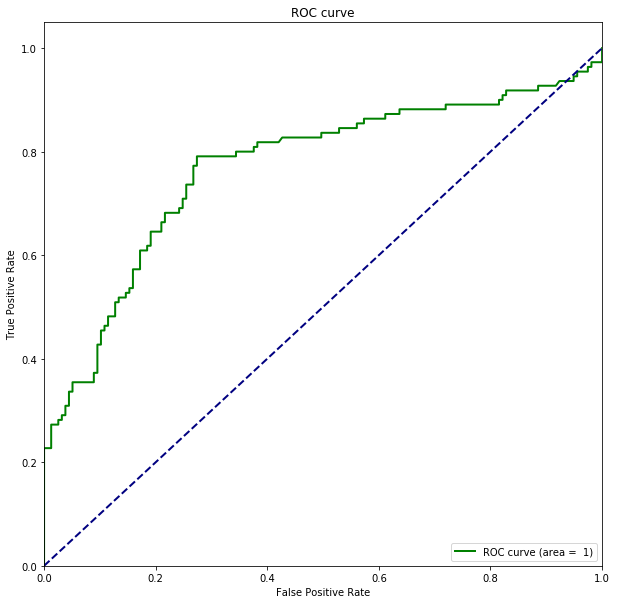

In [78]:
from sklearn.metrics import roc_curve, auc # 두 개의 함수가 모두 들어가 있음. 

pred_test = new_model_logistic.predict_proba(X_test) 
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_test[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %2.f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

### KNN 모델
- k값을 hyper-params로 받음
- 가장 가까운 k개의 데이터를 살펴, 가장 많이 속한 클러스터로 분류해주는 알고리즘

In [79]:
X_KNN = x_data[x_data.columns.difference(['Survived'])] # Survived열 제외 모든 열을 X값으로 
Y_KNN = x_data['Survived'] # Survived열을 y값으로 
model_KNN = neighbors.KNeighborsClassifier(7) 
# KNN은 hyper-param로 K값을 받음.
# k값이 클수록 overfitting일 확률 감소하므로, 너무 작지 않은 최적의 k값을 도출하는 과정이 필요함. 
# 어떻게 최적의 K값을 구할까? 다음 셀 GridSearchCV를 통해 도출. 그 결과값이 7이 나와, k에 7을 넣어줌

# <Feature scaling> 
# - KNN모델은 가장 가까운 데이터 k개를 기반으로 "거리"를 계산하는 과정이 필요함. 각 column의 데이터의 scale을 맞춰주는 정규화 과정을 거쳐야함. 
numeric_features = ['Age','Fare','Ticket Counts','Fare per ticket','est_age'] 
numeric_transformer = StandardScaler() # numeric 열 scaler 생성

categorical_features = ['Pclass','SibSp','Parch','Embarked','Group','Military','Nobility']
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # categorical 열 scaler 생성

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature scaling pipline이 적용된 새로운 "knn모델" 생성
new_model_KNN = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model_KNN)])

# train/testing 데이터 분류
X_train, X_test, y_train, y_test = train_test_split(X_KNN,Y_KNN,test_size=0.3,random_state=0)

new_model_KNN.fit(X_train,y_train) # KNN 모델 학습

# 모델 종류/ x test 데이터/ y test 데이터를 넣었을 때, Accuracy & AUC를 프린트해주는 함수
def print_result(model, X_test, y_test):
    # print('MSE: ', mean_squared_error(clf.predict(X_train), y_train))
    print('-----{}-----'.format(str(model)))
    print('Accuracy(Prediction) score: ', accuracy_score(model.predict(X_test), y_test)) # 올바르게 예측된 데이터 / 전체 데이터
    pred_test = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_test[:,1]) 
    roc_auc = auc(fpr, tpr) 
    print('AUC: ', roc_auc)


print_result(new_model_KNN, X_test, y_test) # KNN모델의 Accuracy & AUC값 프린트

-----Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', StandardScaler(copy=True, with_mean=True, with_std=True), ['Age', 'Fare', 'Ticket Counts', 'Fare per ticket', 'est_age']), ('cat', OneHotEn...ki',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform'))])-----
Accuracy(Prediction) score:  0.7078651685393258
AUC:  0.7646496815286625


In [80]:
# 최적의 K값을 찾아보자 : GridSearchCV 사용. 자동으로 최적의 K값을 찾아줄 것임. (참고: https://realpython.com/knn-python/)
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(model_KNN, parameters)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'n_neighbors': 7}

### Gradient Boost 모델
- 여러 개의 decision tree를 묶어 강력한 model을 만드는 ensemble기법
- 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서 올바르게 예측할 수 있도록 다음 분류기에게 가중치(weight)를 부여하면서 학습과 예측 진행한 모델


In [81]:
# 변수 Group, Embarked, Parch 삭제 // 삭제 이유에 대해서는 추후 영향력 없는 변수를 하나씩 지워가면서 AUC 값 확인

X = x_data[['Age', 'Sex', 'Pclass', 'Fare per ticket', 'est_age']]
Y = x_data[['Survived']]

In [82]:
#GrandientBoostingClassifier 함수 이용하여 Accuarcy score 및 MSE 확인

# 비율 7 : 3으로 분석 진행
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=13)
params = {'n_estimators': 150,   # 반복횟수
          'max_depth': 4,        # 의사결정나무 최대 4번까지 내려갈 것
          'min_samples_split': 5, # 한 항목 당 5개까지 가지 칠 것
          'learning_rate': 0.01}  # 학습계수 0.01

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)

acc = accuracy_score(Y_test, clf.predict(X_test))
print("The accuracy score on test set: {:.4f}".format(acc))

mse = mean_squared_error(Y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


The accuracy score on test set: 0.7978
MSE: 0.2022


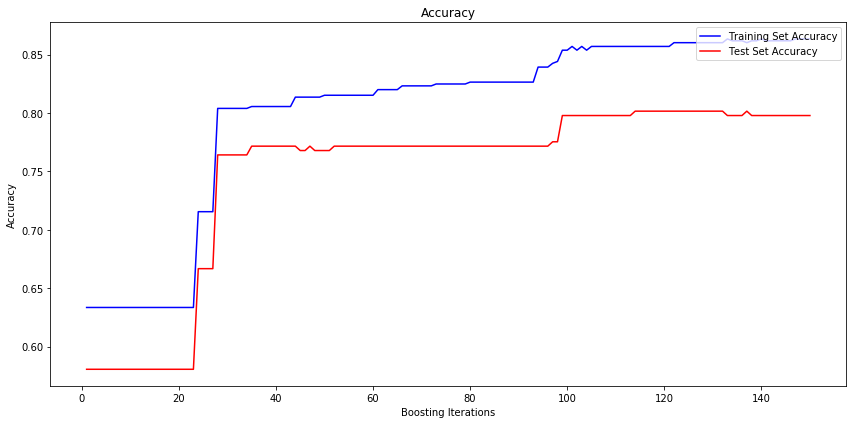

In [83]:
#Accuracy 점수 그래프

train_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict(X_train)):  #각 단계별로 추출값을 뽑아내는 함수 
    train_score[i] = accuracy_score(Y_train, y_pred)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = accuracy_score(Y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') # Binomial deviance loss function for binary classification
plt.plot(np.arange(params['n_estimators']) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()

In [84]:
# pre_X= x_data[x_data.columns.difference(['Survived'])] # y열 제외 모든 x열
# pre_X_train, pre_X_test, Y_train, Y_test = train_test_split(
#     pre_X, Y, test_size=0.3, random_state=0)
# model_GBC = ensemble.GradientBoostingClassifier(**params) # 모든 x열로 학습해줄 새로운 모델을 만들어줍니다
# model_GBC.fit(pre_X_train, Y_train)

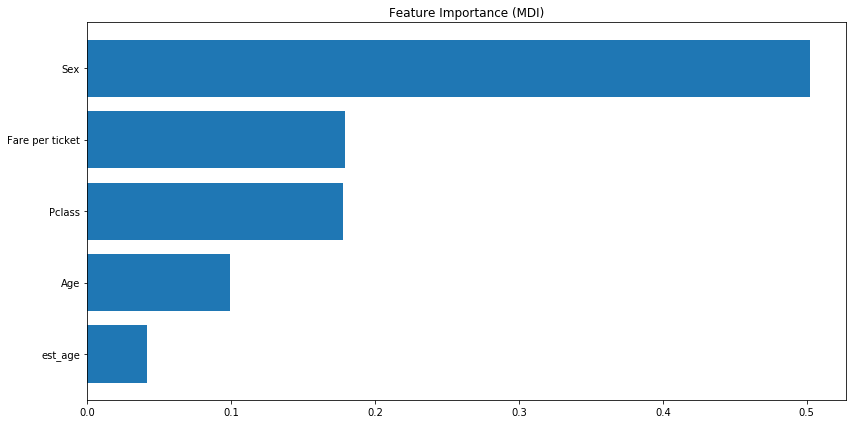

In [85]:
#각 변수별 중요도 확인(해당 그래프를 참고로 중요도가 낮은 변수를 제외하여 설명력 올림)

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(12, 6))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

fig.tight_layout()
plt.show()

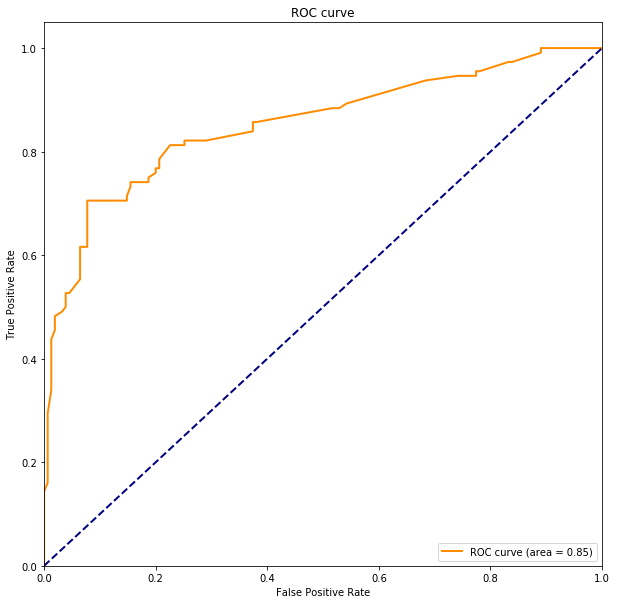

In [86]:
#AUC 그래프 및 점수 확인

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true=Y_test, y_score=clf.predict_proba(X_test)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [87]:
pre_X= x_data[x_data.columns.difference(['Survived'])] # y열 제외 모든 x열
pre_X_train, pre_X_test, Y_train, Y_test = train_test_split(
    pre_X, Y, test_size=0.3, random_state=0)
model_GBC = ensemble.GradientBoostingClassifier(**params) # 모든 x열로 학습해줄 새로운 모델을 만들어줍니다
model_GBC.fit(pre_X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [88]:
# Precision, Recall F1-Score 항목 확인

from sklearn.metrics import classification_report

predictions = clf.predict(X_test)
print(classification_report(Y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf.score(X_train, Y_train)))
print("Accuracy on Test set: {:.3f}".format(clf.score(X_test, Y_test)))

              precision    recall  f1-score   support

           0       0.61      0.73      0.66       157
           1       0.46      0.34      0.39       110

   micro avg       0.57      0.57      0.57       267
   macro avg       0.54      0.53      0.53       267
weighted avg       0.55      0.57      0.55       267

Accuracy on Training set: 0.539
Accuracy on Test set: 0.566


In [89]:
# # GradientBoostingClassfier Grid 작업으로 최적 파라미터 도출 진행 ---- 시간 오래 소요되는파트 (5~10분)

# from sklearn.ensemble import GradientBoostingClassifier

# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import make_scorer
# #creating Scoring parameter: 
# scoring = {'accuracy': make_scorer(accuracy_score),
#            'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# # A sample parameter

# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
#     "n_estimators":[500]
#     }

# clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

# clf.fit(X_train, Y_train)
# print(clf.score(X_train, Y_train))
# print(clf.best_params_)

In [90]:
# 최적 파라미터 Accuracy_Score 및 MSE 확인

acc = accuracy_score(Y_test, clf.predict(X_test))
print("The accuracy score on test set: {:.4f}".format(acc))

mse = mean_squared_error(Y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

The accuracy score on test set: 0.5655
MSE: 0.4345


### LightGBM
- XGBoost와 마찬가지로 weak learner들을 strong learner로 변환시키는 알고리즘
- XGBoost와 예측값에는 큰 차이가 없으나, 훨씬 더 적은 자원을 사용하여 대용량 데이터 처리가 가능함. 빠름.
- (참고) https://lsjsj92.tistory.com/548 

In [91]:
!pip install lightgbm

In [92]:
from lightgbm import LGBMClassifier, plot_importance

model_lgb = LGBMClassifier(n_estimators = 400)
model_lgb.fit(pre_X_train, y_train)
print_result(model_lgb, pre_X_test, y_test) # LightGBM모델의 Accuracy & AUC값 프린트

-----LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)-----
Accuracy(Prediction) score:  0.7865168539325843
AUC:  0.8385639837869137


### RandomForest
- 많은 Decision Tree (n - estimater를)를 기반으로 Random Forest가 만들어짐
- 개별적으로 학습 수행 후 최종적으로 모든 분류기가 voting을 통해 예측 결정
- 사용 이유: Parameter의 많은 수정이 불필요하고 단순하다.
- 트리개수를 뜻하는 n-estimater를 hyper-parameter로 사용함(보통 50개에서 1000개를 사용

In [93]:
X = np.array(x_data[x_data.columns.difference(['Survived'])])
# x값을 Survived를 제외한 모든 features
Y = np.array(x_data[['Survived']])
# y값을 Survived로

model_RF = RandomForestClassifier(n_estimators=100)

#train/test 데이터분류
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=0)
# 7:3 그리고 seed는 0
X, Y = shuffle(X, Y, random_state = 0)
#데이터 섞기 필수는 아님

def train_and_test(model):
# creat a function to put any model 
    model.fit(x_train, y_train)
    # 데이터를 모델에 끼워 줌
    prediction = model.predict(x_train)
    # 모델 예측
    accuracy = round(model.score(X, Y) * 100, 2)
    # 페센트로 나타내도록 함
    print("Accuracy : ", accuracy, "%")
    # print out
    return prediction
    # return to the prediction

rf_pred = train_and_test(model_RF) # 통상적인 갯수가 100 -Tree 갯수

Accuracy :  93.48 %


### SVM모델
-  SVM은 feature의 스케일에 민감하므로, 스케일링 하면 instance 간의 decision boundary가 더 멀리 나타남
- C, gamma를 hyper-parameter로 가지고, gamma 값이 너무 작으면 underfitting, 너무 크면 overfitting이 될 수 있다 


In [94]:
svm_X = x_data[x_data.columns.difference(['Survived'])] # Survived열 제외 모든 열을 X값으로 
svm_Y = np.array(x_data['Survived']) # Survived열을 y값으로



# 모델객체 생성
classifier = SVC(kernel = "rbf", C = 1, gamma = 0.5, probability=True)

# Feature scaling
numeric_features = ['Age','Fare','Ticket Counts','Fare per ticket','est_age'] 
numeric_transformer = StandardScaler() # numeric 열 scaler 생성


categorical_features = ['Pclass','SibSp','Parch','Embarked','Group','Military','Nobility']
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # categorical 열 scaler 생성


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

new_model_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])


X_train, X_test, y_train, y_test = train_test_split(svm_X,svm_Y,test_size=0.3,random_state=0)

new_model_svm.fit(X_train, y_train)


print("Accuracy on Training set: {:.3f}".format(new_model_svm.score(X_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(new_model_svm.score(X_test, y_test)))

Accuracy on Training set: 0.865
Accuracy on Test set: 0.730


### LightGBM
- XGBoost와 마찬가지로 weak learner들을 strong learner로 변환시키는 알고리즘
- XGBoost와 예측값에는 큰 차이가 없으나, 훨씬 더 적은 자원을 사용하여 대용량 데이터 처리가 가능함. 빠름.
- (참고) https://lsjsj92.tistory.com/548 

<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

In [95]:
# pre_X= x_data[x_data.columns.difference(['Survived'])] # y열 제외 모든 x열
# pre_X_train, pre_X_test, Y_train, Y_test = train_test_split(
#     pre_X, Y, test_size=0.3, random_state=0)
# model_GBC = ensemble.GradientBoostingClassifier(**params) # 모든 x열로 학습해줄 새로운 모델을 만들어줍니다
# model_GBC.fit(pre_X_train, Y_train)

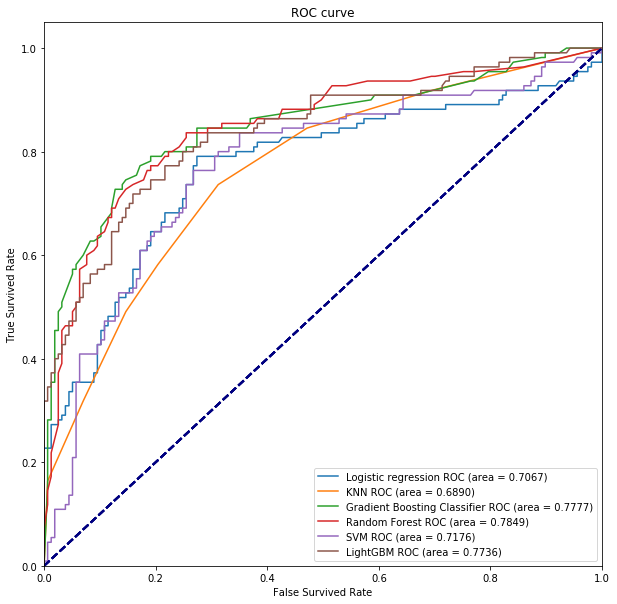

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
models = [
    {
        'label': 'Logistic regression',
        'model': new_model_logistic
    },
    {
        'label': 'KNN',
        'model': new_model_KNN
    },
    {
        'label': 'Gradient Boosting Classifier',
        'model': model_GBC
    },
    {
        'label': 'Random Forest',
        'model': model_RF,
    },
    {
        'label': 'SVM',
        'model': new_model_svm,
    },
    {
        'label': 'LightGBM',
        'model': model_lgb
    }
]
plt.figure(figsize=(10, 10))
for model in models:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model['model'].predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model['model'].predict(X_test))
    plt.plot(fpr, tpr,label='%s ROC (area = %0.4f)' % (model['label'], auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Survived Rate')
    plt.ylabel('True Survived Rate')
    plt.legend(loc="lower right")
    plt.title("ROC curve")
plt.show()